## Common Queuing Disciplines

In [4]:
# for random distributions, random number generators, statistics
import random
import numpy as np
import scipy.stats as stats

# for simulation
import simulus

# for data visualization
import matplotlib.pyplot as plt
%matplotlib inline

# for animation inside the notebook
import ipywidgets as widgets
from ipywidgets import interact

In [5]:
def exp_generator(mean, seed):
    rv = stats.expon(scale=mean)
    rv.random_state = np.random.RandomState(seed)
    while True:
        # 100 random numbers as a batch
        for x in rv.rvs(100):
            yield x

def truncnorm_generator(a, b, seed):
    rv = stats.truncnorm(a, b)
    rv.random_state = np.random.RandomState(seed)
    while True:
        # 100 random numbers as a batch
        for x in rv.rvs(100):
            yield x

In [6]:
def gen_arrivals():
    while True:
        sim.sleep(next(inter_arrival_time))
        sim.process(customer)

def customer():
    server.acquire()
    sim.sleep(next(service_time))
    server.release()

In [7]:
def sim_run(qdis):
    global sim, inter_arrival_time, service_time, server
    sim = simulus.simulator()
    inter_arrival_time = exp_generator(1.2, sim.rng().randrange(2**32))
    service_time = truncnorm_generator(0.8, 1.6, sim.rng().randrange(2**32))
    dc = simulus.DataCollector(system_times='dataseries(all)')
    server = sim.resource(collect=dc, qdis=qdis)
    sim.process(gen_arrivals)
    sim.run(50000)
    return np.array(dc.system_times.data())

In [8]:
random.seed(13579) # global random seed

print('mean wait time:')
w1 = sim_run(simulus.QDIS.FIFO)
print('  FIFO: mean=%g, stdev=%g' % (w1.mean(), w1.std()))
w2 = sim_run(simulus.QDIS.LIFO)
print('  LIFO: mean=%g, stdev=%g' % (w2.mean(), w2.std()))
w3 = sim_run(simulus.QDIS.SIRO)
print('  SIRO: mean=%g, stdev=%g' % (w3.mean(), w3.std()))

mean wait time:
  FIFO: mean=10.1907, stdev=8.73543
  LIFO: mean=10.346, stdev=49.0148
  SIRO: mean=11.2126, stdev=16.5914


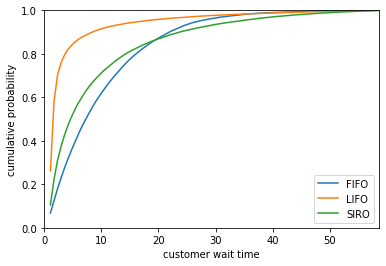

In [9]:
y1, binEdges = np.histogram(w1, bins='auto', density=True)
y2, _ = np.histogram(w2, bins=binEdges, density=True)
y3, _ = np.histogram(w3, bins=binEdges, density=True)
bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
binsize = binEdges[1]-binEdges[0]
plt.plot(bincenters, np.cumsum(y1)*binsize,  label='FIFO')
plt.plot(bincenters, np.cumsum(y2)*binsize, label='LIFO')
plt.plot(bincenters, np.cumsum(y3)*binsize, label='SIRO')
plt.xlim(0,bincenters[-1])
plt.ylim(0,1)
plt.xlabel('customer wait time')
plt.ylabel('cumulative probability')
plt.legend(loc='lower right')
plt.show()

In [10]:
def gen_arrivals():
    while True:
        sim.sleep(next(inter_arrival_time))
        priority = sim.rng().randrange(2)
        sim.process(customer, priority, prio=priority)

def customer(priority):
    t = sim.now
    server.acquire()
    sim.sleep(next(service_time))
    server.release()
    if priority>0: 
        low_waits.append(sim.now-t)
    else:
        high_waits.append(sim.now-t)

In [16]:
def sim_run():
    global sim, inter_arrival_time, service_time, server, low_waits, high_waits
    sim = simulus.simulator()
    inter_arrival_time = exp_generator(1.2, sim.rng().randrange(2**32))
    service_time = truncnorm_generator(0, 1.6, sim.rng().randrange(2**32))
    dc = simulus.DataCollector(system_times='dataseries(all)')
    server = sim.resource(collect=dc, qdis=simulus.QDIS.PRIORITY)
    sim.process(gen_arrivals)
    low_waits, high_waits = [], []
    sim.run(50000)
    return np.array(dc.system_times.data()), np.array(low_waits), np.array(high_waits)

In [17]:
a, b, c = sim_run()
print('all customers: %d, wait time: mean=%g, stdev=%g' % (len(a), a.mean(), a.std()))
print('low priority customers=%d, wait time: mean=%g, stdev=%g' % (len(b), b.mean(), b.std()))
print('high priority customers=%d, wait time: mean=%g, stdev=%g' % (len(c), c.mean(), c.std()))

all customers: 41679, wait time: mean=1.19974, stdev=1.27554
low priority customers=20894, wait time: mean=1.41001, stdev=1.64626
high priority customers=20785, wait time: mean=0.988364, stdev=0.670082


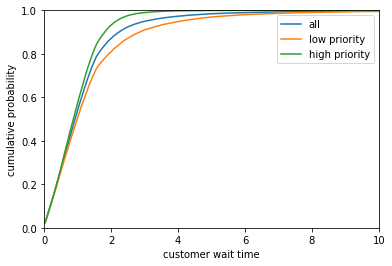

In [18]:
y1, binEdges = np.histogram(a, bins='auto', density=True)
y2, _ = np.histogram(b, bins=binEdges, density=True)
y3, _ = np.histogram(c, bins=binEdges, density=True)
bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
binsize = binEdges[1]-binEdges[0]
plt.plot(bincenters, np.cumsum(y1)*binsize,  label='all')
plt.plot(bincenters, np.cumsum(y2)*binsize, label='low priority')
plt.plot(bincenters, np.cumsum(y3)*binsize, label='high priority')
plt.xlim(0,10)
plt.ylim(0,1)
plt.legend()
plt.xlabel('customer wait time')
plt.ylabel('cumulative probability')
plt.show()